In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import convolve2d

def smooth_exp(D, mode, window):
    """
    Smooth data but do a linear fit at the start to avoid issues with edge effects.
    Useful for exponential bleaching curves.

    Parameters:
    D (numpy.ndarray): Input data array where the first dimension is time.
    mode (str): Smoothing mode, either 'movmedian' or 'movmean'.
    window (int): Window size for smoothing.

    Returns:
    numpy.ndarray: Smoothed data array.
    """
    # First dimension is time
    origsz = D.shape
    D = D.reshape(D.shape[0], -1)
    window = min(window, D.shape[0])
    t = np.arange(1, window + 1)
    p = np.vstack([t, np.ones_like(t)]).T

    if mode == 'movmedian':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).mean().values
    else:
        raise ValueError("Mode must be either 'movmedian' or 'movmean'")

    lVals = np.full((len(t), D.shape[1]), np.nan)
    for ix in range(D.shape[1]):
        inds = np.where(~np.isnan(D[t - 1, ix]))[0]
        if len(inds) > 0:
            slope, intercept, _, _, _ = linregress(inds + 1, D[inds, ix])
            lVals[:, ix] = p @ np.array([slope, intercept])

    weights = t / len(t)
    sVals[t - 1, :] = weights[:, np.newaxis] * sVals[t - 1, :] + (1 - weights[:, np.newaxis]) * lVals

    if mode == 'movmedian':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).mean().values

    sVals[:window, :] = sVals[:window, :] + mVals[:window, :]
    sVals = sVals.reshape(origsz)

    return sVals

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

%matplotlib ipympl

def play_movie(mov, fr=30, gain=1, magnification=1, offset=0):
    """
    Play a movie using matplotlib and ipywidgets.
    
    Parameters:
    ----------
    mov : 3D numpy.ndarray
        Movie, time x height x width
    fr : float, optional
        Frame rate, default is 30
    gain : float, optional
        Multiplier for contrast, default is 1
    magnification : float, optional
        Magnification factor, default is 1
    offset : float, optional
        Offset for contrast, default is 0
        
    Returns:
    -------
    None
    """
    # Ensure mov is a 3D array
    if mov.ndim != 3:
        raise ValueError("Input array mov must be a 3D array")
    
    # Calculate the global min and max for normalization
    minmov = np.nanmin(mov)
    maxmov = np.nanmax(mov)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8*magnification, 6*magnification))
    plt.subplots_adjust(bottom=0.25)
    
    # Display the first frame
    img_display = ax.imshow(mov[:, :, 0], cmap='gray', vmin=minmov, vmax=maxmov)
    ax.axis('off')
    
    def update(frame):
        img = mov[:, :, frame]
        # img = (img - minmov) / (maxmov - minmov)  # Normalize to 0-1
        # img = gain * img + offset  # Apply gain and offset
        # img = np.clip(img, 0, 1)  # Clip to 0-1 range
        
        img_display.set_data(img)
        ax.set_title(f'Frame {frame}')
        fig.canvas.draw_idle()
    
    slider = widgets.IntSlider(min=0, max=mov.shape[2]-1, step=1, description='Frame')
    play_widget = widgets.Play(
        value=0,
        min=0,
        max=mov.shape[2]-1,
        step=1,
        interval=1000/fr,
        description="Press play",
        disabled=False
    )
    
    widgets.jslink((play_widget, 'value'), (slider, 'value'))
    
    ui = widgets.HBox([play_widget, slider])
    display(ui)
    
    def on_slider_change(change):
        update(change['new'])
    
    slider.observe(on_slider_change, names='value')
    
    # Initialize the display
    update(0)


In [3]:
from scipy.io import loadmat
import tempfile
import glob
import re
import cv2
import h5py
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import binary_dilation

from scipy.ndimage import median_filter

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tenacity import retry, stop_after_attempt, wait_fixed
from IPython.core.debugger import set_trace

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Define the retry decorator
@retry(stop=stop_after_attempt(4), wait=wait_fixed(3))
def read_tiff_file(fn):
    print('Reading:', fn)
    A = ScanImageTiffReader(fn)
    Ad = np.array(A.data(), dtype=np.float64).T
    return Ad

In [5]:
import numpy as np
import time
import scipy.ndimage as ndimage
from skimage.filters import difference_of_gaussians
import matplotlib.pyplot as plt
from skimage.morphology import square
import numpy as np
from scipy.linalg import svd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.sparse.linalg import svds
from scipy.ndimage import convolve, shift
from scipy.stats import scoreatpercentile
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.io import savemat, loadmat
import pdb
from sklearn.decomposition import TruncatedSVD

def smoothdata(data, dim, method, window_size, nanflag):
    if method != 'movmedian':
        raise ValueError("Currently only 'movmedian' method is supported.")
    if nanflag not in ['omitnan', 'includenan']:
        raise ValueError("nanflag must be 'omitnan' or 'includenan'.")

    if dim != 3:
        raise ValueError("Currently only smoothing along the 3rd dimension is supported.")
    
    # Assuming data is a 3D numpy array
    smoothed_data = np.copy(data)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if nanflag == 'omitnan':
                smoothed_data[i, j, :] = pd.Series(data[i, j, :]).rolling(window=window_size, center=True, min_periods=1).median()
            else:
                smoothed_data[i, j, :] = pd.Series(data[i, j, :]).rolling(window=window_size, center=True).median()
    
    return smoothed_data

def localize_flashes_bergamo(IM, aData, params, GT, doPlot=True):
    # Inputs:
    # IM:        3D recording, X x Y x Time
    # aData:     alignment metadata
    
    tau = params['tau_s'] / (params['frametime'] * params['dsFac'])  # time constant in frames
    print(f"tau (time constant in frames): {tau}")
    params['tau_frames'] = tau

    sigma = params['sigma_px']  # space constant in pixels
    print(f"sigma (space constant in pixels): {sigma}")

    denoiseWindow = params['denoiseWindow_samps']
    print(f"denoiseWindow: {denoiseWindow}")

    baselineWindow = int(np.ceil(params['baselineWindow_Glu_s'] / (params['frametime'] * params['dsFac'])))
    print(f"baselineWindow: {baselineWindow}")
    
    nans = np.isnan(IM)

    print(f"# Nans:", np.sum(nans))
    
    # Compute the mean image, ignoring NaNs
    IMavg = np.nanmean(IM, axis=2)

    def matlab_percentile(data, percentiles):
        sorted_data = np.sort(data)
        n = len(sorted_data)
        p_rank = 100.0 * (np.arange(n) + 0.5) / n
        return np.interp(percentiles, p_rank, sorted_data, left=sorted_data[0], right=sorted_data[-1])

    IMavg_mat = loadmat('/root/capsule/scratch/IMavg.mat')['IMavg']
    # print('IMavg mat--->', np.allclose(IMavg, IMavg_mat))
    
    # Compute the gamma-corrected image
    IMgamma = np.sqrt(np.maximum(0, IMavg))
    
    # Compute the 10th percentile of the mean image, ignoring NaNs
    # BG = np.nanpercentile(IMavg, 10)
    # BG = np.percentile(IMavg[~np.isnan(IMavg)], 10)
    # BG = 8.664094872076415e+03
    BG = matlab_percentile(IMavg[~np.isnan(IMavg)], 10)
    print(f"BG:", BG)

    IM = np.array(IM, dtype=np.float64)
    BG = np.array(BG, dtype=np.float64)
    
    IM_mat = loadmat('/root/capsule/scratch/IM_mat_raw.mat')['IM']
    # print('IM mat--->', np.allclose(IM, IM_mat,equal_nan=True))

    # Subtract background
    IMf = IM - BG

    # print('IMf ---->', IMf)

    # IMf_BG_mat = loadmat('/root/capsule/scratch/IMf_BG.mat')['IMf']

    # differences = np.where(IMf != IMf_BG_mat)
    # print("Differences at indices:", differences)

    # print(np.allclose(IMf, IMf_BG_mat, equal_nan=True))

    # print('np.nanmax(np.abs(IMf_BG_mat - IMf))', np.nanmax(np.abs(IMf_BG_mat - IMf)))

    # print('np.nanmax(np.abs((IMf_BG_mat - IMf)/(IMf_mat+1e-12)))', np.nanmax(np.abs((IMf_BG_mat - IMf)/(IMf_BG_mat+1e-12))))

    # print('np.all(np.isnan(IMf_BG_mat) == np.isnan(IMf))', np.all(np.isnan(IMf_BG_mat) == np.isnan(IMf)))

    # Set NaN values to 0
    
    IMf[nans] = 0

    # filter_size = int(2 * np.ceil(10 * sigma)) + 1
    
    # # Create a 2D array with zeros
    # DoGfilt = np.zeros((filter_size, filter_size))
    
    # # Set the center element to 1
    # DoGfilt[int(np.ceil(filter_size / 2)), int(np.ceil(filter_size / 2))] = 1
    
    # # Apply Gaussian filters
    # DoGfilt1 = cv2.GaussianBlur(DoGfilt, (0, 0), sigma, sigma)
    # DoGfilt2 = cv2.GaussianBlur(DoGfilt, (0, 0), 5 * sigma, 5 * sigma)
    
    # # Subtract the two filtered images
    # DoGfilt = DoGfilt1 - DoGfilt2
    
    # # Subtract the mean value
    # DoGfilt = DoGfilt - np.mean(DoGfilt)

    filter_size = int(2 * np.ceil(10 * sigma)) + 1

    # Create a 2D array with zeros
    DoGfilt = np.zeros((filter_size, filter_size))

    # Set the center element to 1
    DoGfilt[int(np.ceil(filter_size / 2)-1), int(np.ceil(filter_size / 2)-1)] = 1

    k1 = int(2 * np.ceil(2*sigma)+1)
    k2 = int(2 * np.ceil(10*sigma)+1)

    # Apply Gaussian filters
    DoGfilt1 = cv2.GaussianBlur(DoGfilt, (k1, k1), sigma, None, sigma, borderType = cv2.BORDER_CONSTANT)
    DoGfilt2 = cv2.GaussianBlur(DoGfilt, (k2, k2), 5.0 * sigma, None, 5.0 * sigma, borderType = cv2.BORDER_CONSTANT)

    # Subtract the two filtered images
    DoGfilt = DoGfilt1 - DoGfilt2

    # Subtract the mean value
    DoGfilt = DoGfilt - np.mean(DoGfilt)

    DoGfilt_mat = loadmat('/root/capsule/scratch/DoGfilt.mat')['DoGfilt']  #hardcoded results from matlab
    
    print('DoGfilt ---->', np.allclose(DoGfilt_mat, DoGfilt, equal_nan=True))

    # Apply spatial filter
    # IMf = ndimage.convolve(IMf, np.ones((1, 1, 1)), mode='constant', cval=0.0)
    # # plt.figure()
    # # plt.imshow(IMf[:,:,1])
    # # plt.show()
    IMstruct = cv2.filter2D(np.maximum(0, IMavg.astype(np.float64)), -1, DoGfilt.astype(np.float64), borderType=cv2.BORDER_CONSTANT)
    
    IMstruct_mat = loadmat('/root/capsule/scratch/IMstruct.mat')['IMstruct'] 
    print('IMstruct ---->', IMstruct)
    print('IMstruct matlab ---->', IMstruct_mat)
    print('IMstruct ---->', np.allclose(IMstruct_mat, IMstruct))

    # IMf_before_conv_mat = loadmat('/root/capsule/scratch/IMf_before_conv.mat')['IMf'] 
 
    # print('Imf---->', np.allclose(IMf_before_conv_mat, IMf, equal_nan=True))
    # print('Imf diff---->',np.nanmax(np.abs((IMf_before_conv_mat - IMf)/(IMf_before_conv_mat+1e-12))))
    # print('Imf nan pos---->',np.all(np.isnan(IMf_before_conv_mat) == np.isnan(IMf)))
    
    if IMf.ndim == 3:
        IMf_filtered = np.zeros_like(IMf, dtype=np.float64)
        for i in range(IMf.shape[2]):
            IMf_filtered[:,:,i] = cv2.filter2D(IMf[:,:,i].astype(np.float64), -1, DoGfilt.astype(np.float64), borderType=cv2.BORDER_CONSTANT)
        IMf = IMf_filtered
    else:
        IMf = cv2.filter2D(IMf.astype(np.float64), -1, DoGfilt.astype(np.float64))

    IMf_conv_mat = loadmat('/root/capsule/scratch/IMf_conv.mat')['IMf'] 

    print('IMf_conv ---->', np.allclose(IMf_conv_mat, IMf, equal_nan=True))

    # if IMf.ndim == 3:
    #     IMf_filtered = np.zeros_like(IMf)
    #     for i in range(IMf.shape[2]):
    #         IMf_filtered[:, :, i] = convolve2d(IMf[:, :, i], DoGfilt, mode='same')
    #     IMf = IMf_filtered
    # else:
    #     IMf = convolve2d(IMf, DoGfilt, mode='same')

    # IMstruct = convolve2d(np.maximum(0, IMavg), DoGfilt, mode='same')

    # Highpass filter in time
    IMf[nans] = np.nan
    
    # # Convert the 3D array to a 2D DataFrame for smoothing
    # df = pd.DataFrame(IMf.reshape(-1, IMf.shape[2]))
    
    # # Apply moving median smoothing along the third dimension
    # smoothed = df.apply(lambda x: x.rolling(window=baselineWindow, center=True, min_periods=1).median(), axis=1)
    
    IMf_before_smooth_nans_mat = loadmat('/root/capsule/scratch/IMf_before_smooth_nans.mat')['IMf']
    print('IMf_before_smooth_nanns ---->', np.allclose(IMf_before_smooth_nans_mat, IMf, equal_nan=True))
    # print(np.nanmax(np.abs(IMf_mat - IMf)))

    # print(np.nanmax(np.abs((IMf_mat - IMf)/(IMf_mat+1e-12))))

    # print(np.all(np.isnan(IMf_mat) == np.isnan(IMf)))
    
    # Subtract the smoothed data from the original data
    IMf = IMf - smoothdata(IMf, 3, 'movmedian', baselineWindow, 'omitnan')
    IMf_after_smooth_nans_mat = loadmat('/root/capsule/scratch/IMf_after_smooth_nans.mat')['IMf']
    print('IMf_after_smooth_nans ---->', np.allclose(IMf_after_smooth_nans_mat, IMf, equal_nan=True))
    
    # Reassign NaN values
    # # # IMf[nans] = np.nan

    nans = np.isnan(IMf)
    nans_after_smooth_mat = loadmat('/root/capsule/scratch/nans_after_smooth.mat')['nans']
    print('nans_after_smooth_mat ---->', np.allclose(nans_after_smooth_mat, nans, equal_nan=True))
    
    # # plt.imshow(np.mean(IMf, axis = 2), cmap='jet')
    # # plt.show()

    # Remove motion-associated variance
    IMf = decorrelate_motion(IMf, IMstruct, aData, params)

    # return IMf, IMstruct, aData, params

    # # plt.figure()
    # # plt.imshow(IMf[:,:,1])
    # # plt.show()
    
    # Normalize by expected poisson noise
    IMavg_nans = np.isnan(IMavg)
    print("IMavg_nans", IMavg_nans)

    Pnoise = np.maximum(IMavg, 0)  # squared poisson noise
    Mnoise = np.sqrt(
        cv2.filter2D(np.roll(Pnoise, 1, axis=0) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2 +
        cv2.filter2D(np.roll(Pnoise, -1, axis=0) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2 +
        cv2.filter2D(np.roll(Pnoise, 1, axis=1) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2 +
        cv2.filter2D(np.roll(Pnoise, -1, axis=1) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2
    )


    IMnoise = np.sqrt(cv2.filter2D(Pnoise, -1, np.abs(DoGfilt), borderType=cv2.BORDER_CONSTANT))  # total signal contributing to each measurement
    IMnoise = IMnoise + scoreatpercentile(IMnoise[~IMavg_nans], 33) + 0.2 * np.sqrt(Mnoise)  # add a noise floor to the dimmer pixels
    IMnoise[IMavg_nans] = np.nan
    
    # Add an extra dimension to IMnoise to match the shape of IMf
    IMnoise = IMnoise[:, :, np.newaxis]

    IMf = IMf / IMnoise

    # Temporal matched filter
    IMf[nans] = 0
    mem = IMf[:, :, -1]
    gamma = np.exp(-1 / tau)
    for t in range(IMf.shape[2] - 1, -1, -1):
        IMf[:, :, t] = np.maximum(0, gamma * mem) + (1 - gamma) * IMf[:, :, t]
        mem = IMf[:, :, t]
    IMf[nans] = np.nan

    # Compute a summary image based on skewness
    summary = np.nanmean(IMf**3, axis=2)

    # Create a kernel
    kernel = np.ones((5,5),np.uint8)

    # Perform dilation on the mask of NaN values
    dilated_mask = cv2.dilate(np.isnan(summary).astype(np.uint8), kernel, iterations = 1)

    # Set the dilated areas to NaN
    summary[dilated_mask == 1] = np.nan

    P = get_tiled_peaks(IMf, IMavg, summary)

    # Plot a figure
    if doPlot:
        plot_summary(summary, IMgamma, P, GT)

    return summary, P, params

def plot_summary(summary, IMgamma, P, GT):
    print('Plotting summary---->')
    red = summary / np.nanpercentile(summary, 99)
    cyan = IMgamma / np.nanpercentile(IMgamma, 99)
    rgb = np.dstack((red, cyan, cyan))

    rgb_normalized = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))

    plt.figure()
    # plt.imshow(rgb_normalized)
    plt.imshow( np.dstack((red, cyan, cyan)))

    C_GT = GT[0]
    R_GT = GT[1]
    plt.scatter(P['col'], P['row'], s=10 * (P['val'] / np.mean(P['val'])) ** 2, edgecolors='m', facecolors='none')
    plt.scatter(R_GT, C_GT, marker='x', c='yellow', s=100)
    plt.show()

def get_tiled_peaks(IM, IMavg, summary):
    nan_mask = np.isnan(IM).astype(np.uint8)

    # Create a 5x5 kernel of ones
    kernel = np.ones((5, 5), np.uint8)

    dilated = np.empty_like(nan_mask)
    for i in range(nan_mask.shape[2]):
        dilated[:, :, i] = cv2.dilate(nan_mask[:, :, i], kernel)

    # Invert the result to get the valid mask
    valid = ~dilated.astype(bool)
    peaks = valid
    
    for dim in range(3):
        peaks = peaks & (IM > np.roll(IM, 1, axis=dim)) & (IM > np.roll(IM, -1, axis=dim))
        
    # linInds = np.where(peaks)
    # vvv = IM[linInds]
    # rrr, ccc, ttt = linInds

    linInds = np.where(peaks.flatten())[0]
    vvv = IM.flatten()[linInds]
    rrr, ccc, ttt = np.unravel_index(linInds, peaks.shape)

    print("rrr, ccc, ttt, peaks.shape, linInds:", len(rrr), len(ccc), len(ttt), peaks.shape, len(linInds))

    sz = IM.shape
    tilesize = 64
    tilestartsR = np.arange(1, sz[0] - tilesize // 4, tilesize // 2)
    tileendsR = np.minimum(sz[0], tilestartsR + tilesize - 1)
    tilestartsC = np.arange(1, sz[1] - tilesize // 4, tilesize // 2)
    tileendsC = np.minimum(sz[1], tilestartsC + tilesize - 1)

    summaryVals = summary[rrr, ccc]

    keep = np.zeros(len(ttt), dtype=bool)  # which events to keep
    vNorm = np.zeros(len(ttt))  # the event sizes, Z-scored

    for rix in range(len(tilestartsR)):
        for cix in range(len(tilestartsC)):
            selStats = (rrr >= tilestartsR[max(0, rix-1)]) & (rrr <= tileendsR[min(len(tileendsR)-1, rix+1)]) & \
                    (ccc >= tilestartsC[max(0, cix-1)]) & (ccc <= tileendsC[min(len(tileendsC)-1, cix+1)])

            S = summary[tilestartsR[max(0, rix-1)]:tileendsR[min(len(tileendsR)-1, rix+1)]+1, 
                        tilestartsC[max(0, cix-1)]:tileendsC[min(len(tileendsC)-1, cix+1)]+1]
            Sp = np.percentile(S.flatten(), [1, 33])
            Sthresh = Sp[1] + 5 * (Sp[1] - Sp[0])
            selS = summaryVals > Sthresh

            vals = vvv[selStats & selS]
            ptile = np.percentile(vals, [1, 50])
            vals = 3 * (vals - ptile[1]) / (ptile[1] - ptile[0])
            thresh = ptile[1] + 5 * (ptile[1] - ptile[0])  # threshold is 2*[98% confint], corresponding to an SNR of ~6
            selTile = (rrr >= tilestartsR[rix]) & (rrr <= tileendsR[rix]) & \
                    (ccc >= tilestartsC[cix]) & (ccc <= tileendsC[cix]) & (vvv > thresh) & selS
            keep[selTile] = True
            vNorm[selStats & selS] = np.maximum(vNorm[selStats & selS], vals)


    rrr = rrr[keep]
    ccc = ccc[keep]
    ttt = ttt[keep]
    vvv = vNorm[keep]

    # Upsample for superresolution
    pR = []
    pC = []

    for peakIx in range(len(ttt)-1, -1, -1):
        R = IM[rrr[peakIx]+np.arange(-1,2), ccc[peakIx], ttt[peakIx]]
        C = IM[rrr[peakIx], ccc[peakIx]+np.arange(-1,2), ttt[peakIx]]

        ratioR = min(1e6, (R[1] - R[0]) / (R[1] - R[2]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        pR.append(rrr[peakIx] - dR)

        ratioC = min(1e6, (C[1] - C[0]) / (C[1] - C[2]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        pC.append(ccc[peakIx] - dC)

    print("pR.shape:", len(pR))
    P = {'row': pR, 'col': pC, 't': ttt, 'val': vvv}
    return P

def decorrelate_motion(IM, IMstruct, aData, window):
    IMavg = IMstruct

    nanFrames = np.all(np.isnan(IM), axis=(0, 1))

    # Replace NaNs with zeros
    IMnan = np.isnan(IM)
    goodPixels = np.mean(~IMnan, axis=2) > 0.9

    IM2 = IM.copy()
    IM2[IMnan] = 0
    
    # Select non-NaN frames
    IM2 = IM2[:, :, ~nanFrames]

    # Reshape
    sz = IM2.shape
    IM2 = IM2.reshape(sz[0] * sz[1], sz[2], order='F')

    # Subtract mean
    IM2 = IM2.astype(np.float64)  # Convert IM2 to double precision
    IM2 = IM2 - np.mean(IM2, axis=1, keepdims=True)

    # Function to translate the image
    def translate_image(image, x_shift, y_shift):
        rows, cols = image.shape[:2]
        M = np.float64([[1, 0, x_shift], [0, 1, y_shift]])
        translated_image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_LINEAR)
        return translated_image

    # Translate the image in four directions
    translated_right = translate_image(IMavg, 1, 0)
    translated_down = translate_image(IMavg, 0, 1)
    translated_left = translate_image(IMavg, -1, 0)
    translated_up = translate_image(IMavg, 0, -1)

    # Compute the gradients
    grad_right = IMavg - translated_right
    grad_down = IMavg - translated_down
    grad_left = IMavg - translated_left
    grad_up = IMavg - translated_up

    # Concatenate the gradients along a new third dimension
    imageGrads = np.stack((grad_right, grad_down, grad_left, grad_up), axis=-1)

    imageGrads = imageGrads.reshape(sz[0] * sz[1], -1, order='F')

    nPCs = 20

    # Select the rows of IM2 corresponding to goodPixels
    IM2_subset = IM2[goodPixels.flatten(order = 'F'), :]

    # Perform SVD
    svd = TruncatedSVD(n_components=nPCs, algorithm='arpack', n_iter=15)
    U = svd.fit_transform(IM2_subset)
    S = svd.singular_values_
    Vt = svd.components_

    U = U/S[None, :]

    # Assuming imageGrads and U are numpy arrays
    X = imageGrads[goodPixels.flatten(order = 'F'), :]
    y = U

    # Create a LinearRegression object
    model = LinearRegression()

    # Fit the model to the data
    model.fit(X, y)

    # Get the coefficients (equivalent to b in MATLAB code)
    bt = model.coef_
    b = bt.T
    correction = (imageGrads @ b) @ np.diag(S) @ Vt

    IM[:, :, ~nanFrames] -= np.reshape(correction, (sz[0], sz[1], -1), order='F')
    return IM

In [10]:
def xcorr2_nans(frame, template, shiftsCenter, dShift):
    """
    Perform a somewhat-efficient local normalized cross-correlation for images with NaNs.
    
    Parameters:
    - frame: the frame to be aligned; this has more NaNs
    - template: the template
    - shiftsCenter: the center offset around which to perform a local search
    - dShift: the maximum shift (scalar, in pixels) to consider on each axis around shiftsCenter
    
    Returns:
    - motion: the calculated motion vector
    - R: the correlation coefficient
    """
    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.bool_)
    
    # Valid pixels of the new frame
    fValid = ~np.isnan(frame) & shift(~binary_dilation(np.isnan(template), structure=SE), shiftsCenter)
    fValid[:dShift, :] = False
    fValid[-dShift:, :] = False
    fValid[:, :dShift] = False
    fValid[:, -dShift:] = False

    # shiftsCenter = np.array(shiftsCenter) 
    tValid = np.roll(fValid, shift=-np.array(shiftsCenter))

    # F = frame[fValid]  # fixed data

    # Flatten both arrays in column-major order
    frame_flattened = frame.flatten(order='F')
    fValid_flattened = fValid.flatten(order='F')

    # Use the flattened boolean array to index the flattened frame array
    F = frame_flattened[fValid_flattened]
    
    ssF = np.sqrt(np.sum(F**2))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    shifts = np.arange(-dShift, dShift + 1)

    C = np.full((len(shifts), len(shifts)), np.nan)

    # Flatten the template array in column-major order
    template_flattened = template.flatten(order='F')

    # Iterate over the shifts
    for drix in range(len(shifts)):
        for dcix in range(len(shifts)):
            # Roll the tValid array
            rolled_tValid = np.roll(tValid, (-shifts[drix], shifts[dcix]), axis=(1, 0))
            
            # Flatten the rolled tValid array in column-major order
            rolled_tValid_flattened = rolled_tValid.flatten(order='F')

            # Apply boolean indexing to get the template values
            T = template_flattened[rolled_tValid_flattened]

            # Calculate ssT and C
            ssT = np.sum(T**2)
            C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)

    C = C.T[::-1] # To match the way matlab computes

    # Find maximum of correlation map
    maxval = np.max(C)
    I = np.argmax(C)
    if np.isnan(maxval):
        raise ValueError("All-NaN slice encountered in cross-correlation.")
    
    rr, cc = np.unravel_index(np.nanargmax(C), C.shape)
    R = maxval / ssF  # correlation coefficient

    if rr > 1 and rr < len(shifts) and cc > 1 and cc < len(shifts):
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2

        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2

        motion = shiftsCenter + np.array([shifts[rr] - dR, shifts[cc] - dC])
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + np.array([shifts[rr], shifts[cc]])

    if np.any(np.isnan(motion)):
        raise ValueError("NaN encountered in motion calculation.")

    return motion, R


def make_template_multi_roi(Y, maxshift):

    if len(Y.shape) == 2:
        Y = np.expand_dims(Y, axis=2)
        
    sz = Y.shape    
    R = np.ones((sz[2], sz[2]))
    motion = np.zeros((2, sz[2], sz[2]))

    for f1 in range(sz[2]):
        for f2 in range(f1 + 1, sz[2]):
            m1, _ = xcorr2_nans(Y[:, :, f2], Y[:, :, f1], [0, 0], maxshift)
            motion[:, f1, f2], R[f1, f2] = xcorr2_nans(Y[:, :, f2], Y[:, :, f1], np.round(m1).astype(int), maxshift)
            motion[:, f2, f1] = -motion[:, f1, f2]
            R[f2, f1] = R[f1, f2]

    bestR = np.max(np.median(R, axis=0))
    maxind = np.argmax(np.median(R, axis=0))
    frameInds = np.where(R[:, maxind] >= bestR)[0]

    # Create view matrices for interpolation
    viewR, viewC = np.meshgrid(
        np.arange(1, sz[0] + 2 * maxshift + 1) - maxshift,
        np.arange(1, sz[1] + 2 * maxshift + 1) - maxshift,
        indexing='ij'
    )

    # Initialize the template with NaNs
    template = np.full((2 * maxshift + sz[0], 2 * maxshift + sz[1], len(frameInds)), np.nan)

    # Interpolate for each frame index
    for fix in range(len(frameInds)):
        # Calculate the map for remapping
        map_x = (viewC - motion[1, frameInds[fix], maxind]).astype(np.float32)
        map_y = (viewR - motion[0, frameInds[fix], maxind]).astype(np.float32)

        # Perform interpolation using cv2.remap
        template[:, :, fix] = cv2.remap(
            Y[:, :, frameInds[fix]].astype(np.float32),
            map_x,
            map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=np.nan
        )
        
    template = np.nanmean(template, axis=2)

    
    template = template[:,:,np.newaxis]  # Add a third axis
    # Perform the operation
    template[np.sum(np.isnan(template), axis=2) > np.floor(template.shape[2] / 2)] = np.nan

    template = np.squeeze(template, axis=2)  # Squeeze the third axis

    return template

In [7]:
import numpy as np
import cv2
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

def cluster_localizations(peaks, params):
    sz = params['sz']  # XY size of the summary image
    upsample = params['upsample']
    amp_thresh = min(peaks['val'])
    n_events_total = len(peaks['val'])
    kernel_sigma = 1 / upsample
    r_grid = np.linspace(1, sz[0], upsample * sz[0] + 1)
    c_grid = np.linspace(1, sz[1], upsample * sz[1] + 1)
    rr, cc = np.meshgrid(r_grid, c_grid, indexing='ij')
    density = np.zeros(rr.shape)

    for e_ix in range(n_events_total):
        r_min = peaks['row'][e_ix] - (8 * kernel_sigma)
        r_max = peaks['row'][e_ix] + (8 * kernel_sigma)
        c_min = peaks['col'][e_ix] - (8 * kernel_sigma)
        c_max = peaks['col'][e_ix] + (8 * kernel_sigma)
        r_sel = (r_grid > r_min) & (r_grid < r_max)
        c_sel = (c_grid > c_min) & (c_grid < c_max)

        # Correct boolean indexing using np.ix_
        r_sel_indices = np.where(r_sel)[0]
        c_sel_indices = np.where(c_sel)[0]
        r_loc = rr[np.ix_(r_sel_indices, c_sel_indices)]
        c_loc = cc[np.ix_(r_sel_indices, c_sel_indices)]
        A = multivariate_normal.pdf(np.column_stack((r_loc.ravel(), c_loc.ravel())), mean=[peaks['row'][e_ix], peaks['col'][e_ix]], cov=kernel_sigma * np.eye(2))
        A *= (peaks['val'][e_ix] / np.max(A))

        density[np.ix_(r_sel_indices, c_sel_indices)] += A.reshape(r_loc.shape)

    deconv_sigma = np.sqrt(2) * upsample * params['sigma_px'] / np.sqrt(amp_thresh)  # sigmaXY/sqrt(amp)
    filt_size = 2 * np.ceil(3 * deconv_sigma).astype(int) + 1
    sel_rows = cv2.dilate(np.any(density, axis=1).astype(np.uint8), np.ones((filt_size, 1), np.uint8)).astype(bool)
    sel_cols = cv2.dilate(np.any(density, axis=0).astype(np.uint8), np.ones((1, filt_size), np.uint8)).astype(bool)
    PSF = cv2.getGaussianKernel(filt_size, deconv_sigma) * cv2.getGaussianKernel(filt_size, deconv_sigma).T
    IMest = density.copy()

    # Ensure that sel_rows and sel_cols are 1-dimensional
    sel_row_indices = np.where(sel_rows)[0]
    sel_col_indices = np.where(sel_cols)[0]
    IMest[np.ix_(sel_row_indices, sel_col_indices)] = cv2.filter2D(IMest[np.ix_(sel_row_indices, sel_col_indices)], -1, PSF)

    BW = (maximum_filter(IMest, size=3) == IMest) & (IMest > np.mean(IMest[IMest > 0]))
    max_r, max_c = np.where(BW)
    V, sortorder = np.sort(IMest[BW])[::-1], np.argsort(IMest[BW])[::-1]
    max_r, max_c = max_r[sortorder], max_c[sortorder]

    keep = np.ones(V.shape, dtype=bool)
    d_maxima = squareform(pdist(np.column_stack((max_r, max_c))))
    np.fill_diagonal(d_maxima, np.inf)

    for v_ix in range(len(V)):
        if not np.isnan(d_maxima[v_ix, v_ix]):
            sel = d_maxima[v_ix, :] < upsample
            d_maxima[sel, :] = np.nan
            d_maxima[:, sel] = np.nan
            keep[sel] = False
    max_r, max_c, V = max_r[keep], max_c[keep], V[keep]
    k = len(V)
    source_r, source_c = r_grid[max_r], c_grid[max_c]

    weights = np.ones(k)
    assignments = np.zeros(n_events_total)
    done = False
    ksigma = (upsample * params['sigma_px'] / np.sqrt(2 * amp_thresh))

    while not done:
        z_score = np.sqrt((source_r[:, None] - peaks['row']) ** 2 + (source_c[:, None] - peaks['col']) ** 2) / ksigma
        z_score[z_score > 2] = np.inf
        likelihoods = normpdf(z_score) * weights[:, None]
        max_val, max_inds = np.max(likelihoods, axis=0), np.argmax(likelihoods, axis=0)
        max_inds[max_val == 0] = 0  # unassigned points

        if np.array_equal(max_inds, assignments):
            done = True
            keep_events = np.min(z_score, axis=0) < 2
            keep_sources = np.zeros(k, dtype=bool)
            for ix in range(k - 1, -1, -1):
                keep_sources[ix] = np.sum(assignments == ix) >= params['minEvents']
                keep_events[assignments == ix] = keep_sources[ix]
            peaks['row'], peaks['col'], peaks['val'], peaks['t'] = peaks['row'][keep_events], peaks['col'][keep_events], peaks['val'][keep_events], peaks['t'][keep_events]
            source_r, source_c, weights = source_r[keep_sources], source_c[keep_sources], weights[keep_sources]
            k = np.sum(keep_sources)

            z_score = np.sqrt((source_r[:, None] - peaks['row']) ** 2 + (source_c[:, None] - peaks['col']) ** 2) / ksigma
            z_score[z_score > 2] = np.inf
            likelihoods = normpdf(z_score) * weights[:, None]
            _, assignments = np.max(likelihoods, axis=0), np.argmax(likelihoods, axis=0)
        else:
            assignments = max_inds
            for ii in range(k):
                sel = assignments == ii
                if np.any(sel):
                    source_r[ii] = np.mean(peaks['row'][sel])
                    source_c[ii] = np.mean(peaks['col'][sel])
                    weights[ii] = np.sqrt(np.sum(sel))
                    
    peaks['assignments'], peaks['assignProbs'] = assignments, likelihoods / likelihoods.sum(axis=1)[:, None]

    plt.figure('Event assignments to sources')
    plt.imshow(density, extent=[c_grid.min(), c_grid.max(), r_grid.min(), r_grid.max()])
    colors = plt.cm.hsv(np.linspace(0, 1, k))
    for source_ix in range(k):
        assignments_sel = peaks['assignments'] == source_ix
        plt.scatter(source_c[source_ix], source_r[source_ix], 300, marker='x', edgecolor=colors[source_ix], linewidth=2)
        plt.scatter(peaks['col'][assignments_sel], peaks['row'][assignments_sel], edgecolor=colors[source_ix])
    plt.show()

    return density, peaks, source_r, source_c, params

def normpdf(x):
    """Compute the normal probability density function."""
    return np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)


Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial4_DOWNSAMPLED-2x.tif
Trial: 8
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial9_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial9_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial9_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 837100
BG: 8664.094872076415
DoGfilt ----> True
IMstruct ----> [[ 1744.66480461  2950.02651154  3188.50706123 ...  1015.77260216
   2410.36128891  1438.74613935]
 [ 3124.44745927  4793.07952101  5121.28088995 ...  4399.05371249
   6242.54489466  4521.55187964]
 [ 3611.55282994  5431.31457465  5722.42478632 ...  6426.7327366

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038055681334405486..86.99087329969666].


rrr, ccc, ttt, peaks.shape, linInds: 365548 365548 365548 (45, 121, 5000) 365548
pR.shape: 453
Plotting summary---->


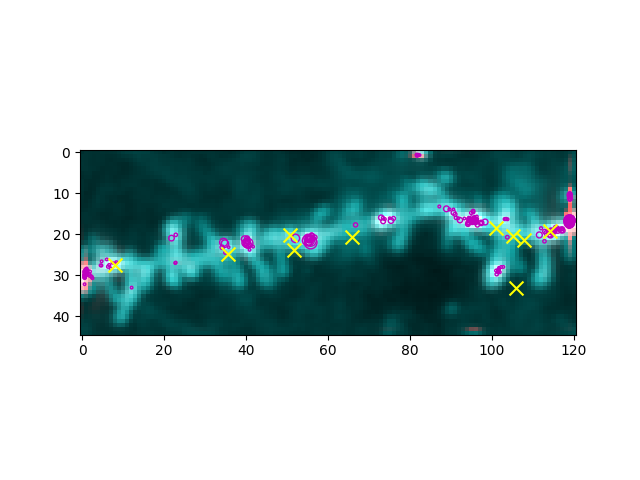

Trial: 7
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial8_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial8_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial8_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 838112
BG: 8651.592963122559
DoGfilt ----> True
IMstruct ----> [[ 1843.54781934  3031.18990385  3226.8807781  ...  1097.42700656
   2261.64596788  1094.41359769]
 [ 3227.05569538  4868.13126289  5142.90408134 ...  4444.58853328
   5954.02371087  3961.83946033]
 [ 3686.72454403  5473.56066401  5713.10644243 ...  6463.46408843
   8258.09251739  5578.82882261]
 ...
 [-4278.46292121 -3227.46417354 -4855.99807919 ... 10189.43774001
   9042.4490062   5437.963

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003458850789936561..87.38141195088569].


rrr, ccc, ttt, peaks.shape, linInds: 368310 368310 368310 (45, 121, 5000) 368310
pR.shape: 412
Plotting summary---->


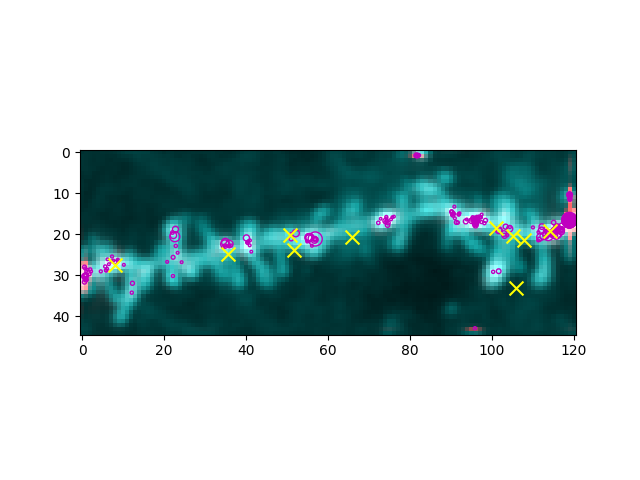

Trial: 6
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial7_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial7_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial7_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 839300
BG: 8654.370094238282
DoGfilt ----> True
IMstruct ----> [[ 1768.63979792  2968.43370192  3201.38510676 ...  1053.36664219
   2440.51872663  1443.43262188]
 [ 3154.85516318  4821.7154171   5141.45736808 ...  4443.69533504
   6253.08290019  4487.25450321]
 [ 3636.14992631  5458.83399378  5740.09931756 ...  6482.17500866
   8624.21796806  6203.70842514]
 ...
 [-4231.62123396 -3104.05105401 -4653.36608501 ... 10367.51186461
   9413.85599081  5899.535

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004287696866539041..106.65579367570386].


rrr, ccc, ttt, peaks.shape, linInds: 367282 367282 367282 (45, 121, 5000) 367282
pR.shape: 416
Plotting summary---->


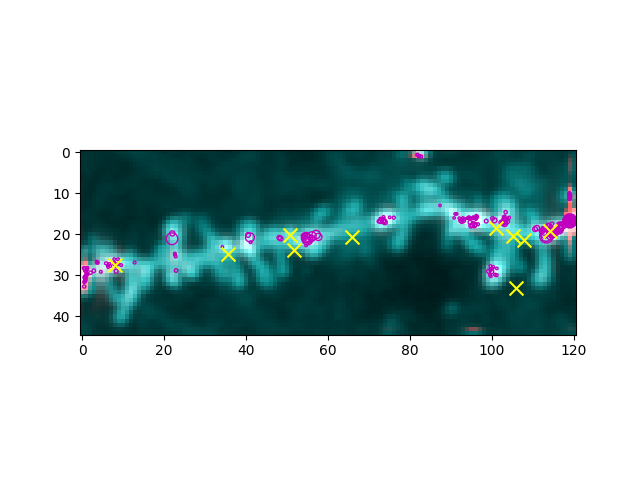

Trial: 5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial6_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial6_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial6_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 832788
BG: 8656.879900830078
DoGfilt ----> True
IMstruct ----> [[ 1815.30732544  3018.37967546  3234.26765804 ...  1037.00028742
   2344.96785123  1299.06890452]
 [ 3207.22120407  4871.63072982  5169.66594202 ...  4409.8900151
   6108.19925812  4270.96338535]
 [ 3677.83650861  5489.80323412  5750.34920657 ...  6462.67716054
   8476.43388623  5963.85721175]
 ...
 [-4263.01212846 -3149.9431608  -4726.60480053 ... 10385.94736391
   9377.47917205  5819.5547

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004724723871769481..74.0714729970452].


rrr, ccc, ttt, peaks.shape, linInds: 367538 367538 367538 (45, 121, 5000) 367538
pR.shape: 339
Plotting summary---->


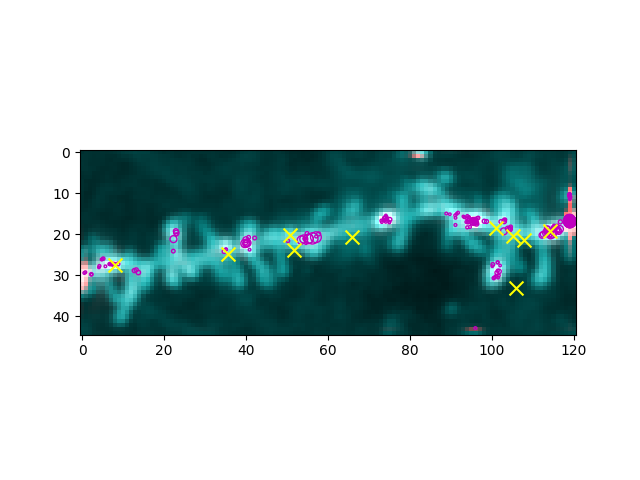

Trial: 4
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial5_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial5_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial5_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 840092
BG: 8657.597747580903
DoGfilt ----> True
IMstruct ----> [[ 1798.51599015  2998.32611341  3226.89334763 ...  1073.48487705
   2346.79196153  1256.0587638 ]
 [ 3181.68401437  4842.41211028  5155.82674939 ...  4455.08002515
   6105.85734317  4209.97573365]
 [ 3659.6106133   5466.10180565  5736.58834057 ...  6478.59890247
   8431.29911455  5860.95998511]
 ...
 [-4305.57718832 -3230.43342957 -4796.74005027 ... 10289.76606914
   9261.25649504  5714.711

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0014617005744980308..91.37074153564318].


rrr, ccc, ttt, peaks.shape, linInds: 365939 365939 365939 (45, 121, 5000) 365939
pR.shape: 380
Plotting summary---->


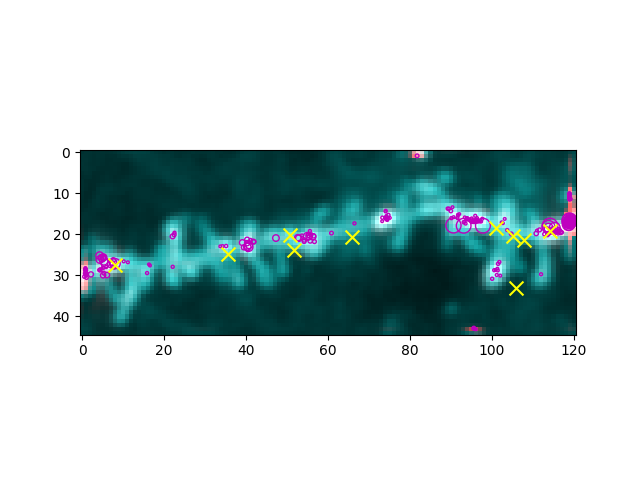

Trial: 3
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial4_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial4_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial4_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 842512
BG: 8664.54764840088
DoGfilt ----> True
IMstruct ----> [[ 1781.40887482  2971.43318831  3185.43638785 ...  1085.71367642
   2438.14734369  1391.74053846]
 [ 3166.22248577  4817.29802437  5111.65387245 ...  4502.01679874
   6272.44085723  4442.99408457]
 [ 3647.05657214  5451.94952414  5711.2022565  ...  6559.46216923
   8657.10881073  6163.7027739 ]
 ...
 [-4228.68987025 -3111.76781651 -4677.98280975 ... 10426.53651381
   9465.03671627  5934.8413

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0054033751201884115..100.70808328722353].


rrr, ccc, ttt, peaks.shape, linInds: 366995 366995 366995 (45, 121, 5000) 366995
pR.shape: 340
Plotting summary---->


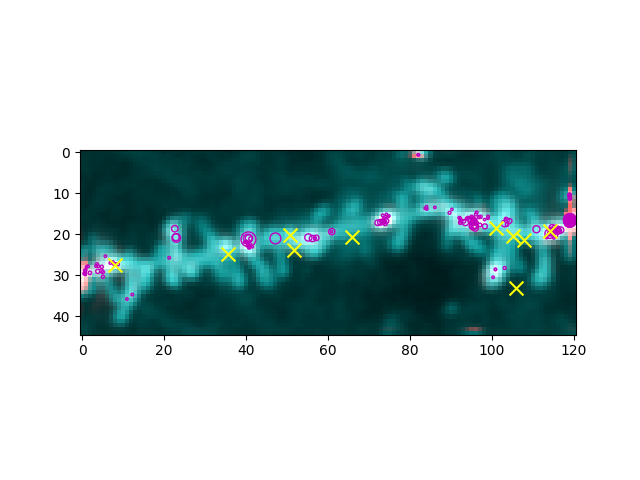

Trial: 2
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial3_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial3_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial3_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 841676
BG: 8623.673969250489
DoGfilt ----> True
IMstruct ----> [[ 1848.56154683  3041.40116862  3240.69361382 ...  1016.5514591
   2236.39711465  1139.93949551]
 [ 3249.1496039   4903.04213862  5178.86663572 ...  4365.69224398
   5968.54314391  4079.13316171]
 [ 3727.27024325  5536.05012189  5775.19677545 ...  6390.51672165
   8308.65682561  5750.80514082]
 ...
 [-4227.2115274  -3116.60005434 -4691.30397275 ... 10272.20899939
   9230.18589666  5671.4821

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0049062141883339525..77.00818911496434].


rrr, ccc, ttt, peaks.shape, linInds: 367592 367592 367592 (45, 121, 5000) 367592
pR.shape: 450
Plotting summary---->


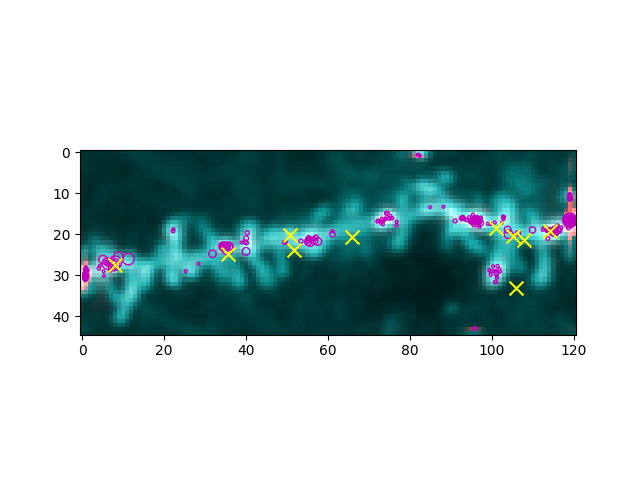

Trial: 1
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial2_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial2_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial2_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 836396
BG: 8658.587646899414
DoGfilt ----> True
IMstruct ----> [[ 1812.78693662  3010.57582421  3225.17015057 ...  1065.47654923
   2289.53019142  1183.63106962]
 [ 3192.42028875  4848.14453495  5144.8607767  ...  4428.82379008
   6003.51561133  4084.12011099]
 [ 3662.93797092  5468.04612115  5729.40248726 ...  6453.44902987
   8303.39093912  5693.76158762]
 ...
 [-4269.07278334 -3190.12776152 -4774.8707306  ... 10211.98384794
   9109.90231015  5533.664

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003738734876449218..64.6280141935455].


rrr, ccc, ttt, peaks.shape, linInds: 368146 368146 368146 (45, 121, 5000) 368146
pR.shape: 356
Plotting summary---->


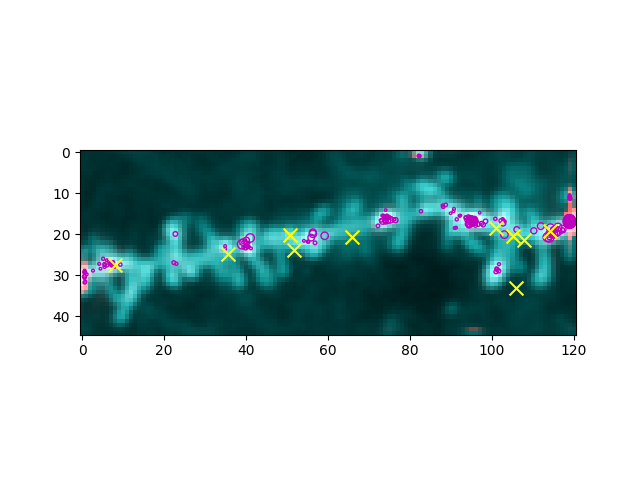

Trial: 0
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial1_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial1_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial1_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 830632
BG: 8636.78383861084
DoGfilt ----> True
IMstruct ----> [[ 1842.9911529   3046.97734378  3264.13111318 ...  1072.67513515
   2161.01816537   962.84561167]
 [ 3236.05384156  4893.75629552  5186.19999929 ...  4419.00299633
   5819.48850269  3778.79230031]
 [ 3708.01574198  5503.20098132  5748.06881943 ...  6443.39325578
   8098.62161274  5348.38597068]
 ...
 [-4239.99593686 -3166.50564939 -4767.19638776 ... 10222.20501052
   9045.4222189   5411.6481

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005027907322782686..45.449258050425755].


rrr, ccc, ttt, peaks.shape, linInds: 367762 367762 367762 (45, 121, 5000) 367762
pR.shape: 267
Plotting summary---->


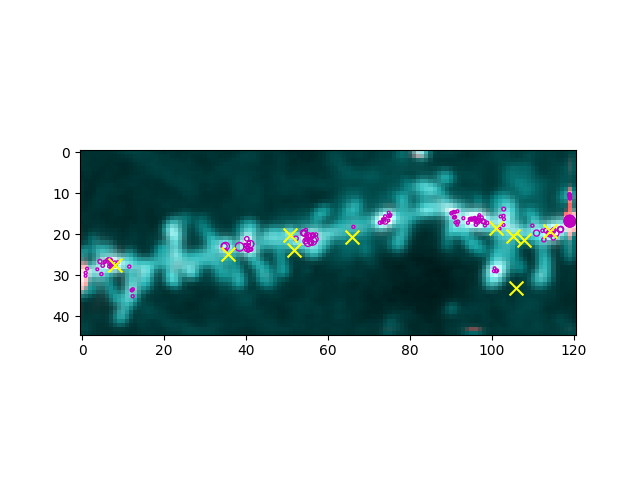

In [8]:
import os
import glob
import pandas as pd
import re
import tempfile
import h5py
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader

savedr = '/root/capsule/scratch/test1/'

# Define the directory path
fns = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/'

GT_fns = "/root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/"
h5_files = sorted(glob.glob(GT_fns + "*.h5"))

# Define the pattern to match files
pattern = os.path.join(fns, '*_Trial*_DOWNSAMPLED-2x.tif')

# Use glob to find all files matching the initial pattern
initial_matching_files = glob.glob(pattern)

# Define a regular expression to match files ending with 'Trial<int>.tif'
regex = re.compile(r'.*_Trial\d+_DOWNSAMPLED-2x.tif$')

# Filter the files using the regular expression
strict_matching_files = [f for f in initial_matching_files if regex.match(f)]

params = {
    "tau_s": 0.027,  # time constant in seconds for glutamate channel; from Aggarwal et al 2023 Fig 5
    "sigma_px": 1.33,  # space constant in pixels
    "eventRateThresh_hz": 1/10,  # minimum event rate in Hz
    "sparseFac": 0.1,  # sparsity factor for shrinking sources in space, 0-1, higher value makes things sparser
    "nmfIter": 5,  # number of iterations of NMF refinement
    "dXY": 3,  # how large sources can be (radius), pixels
    "upsample": 3,  # how many times to upsample the imaging resolution for finding local maxima to identify sources; affects maximum source density
    "nmfBackgroundComps": 0,  # <=4, max number of background components to use for NMF. If 0, we compute F0 instead of fitting background
    "denoiseWindow_samps": 35,  # number of samples to average together for denoising
    "baselineWindow_Glu_s": 2,  # timescale for calculating F0 in glutamate channel, seconds
    "baselineWindow_Ca_s": 2  # timescale for calculating F0 in calcium channel, seconds
}

# Path to the original HDF5 file
original_gt_path = [
    os.path.join(
        os.path.dirname(path),
        re.sub(r'Trial\d+_DOWNSAMPLED-2x.tif$', f'Trial{trial_num}_ALIGNMENTDATA.h5', os.path.basename(path))
    )
    for trial_num, path in enumerate(strict_matching_files, start=1)
]

# Process the TIFF files
discardFrames = [None] * len(strict_matching_files)
rawIMs = [None] * len(strict_matching_files)
peaks = [None] * len(strict_matching_files)

# Read the first file to get the shape
first_fn = strict_matching_files[0]
first_IM = read_tiff_file(first_fn)

# Initialize meanIM
meanIM = np.full((first_IM.shape[0], first_IM.shape[1], 1, len(strict_matching_files)), np.nan)
actIM = np.full((first_IM.shape[0], first_IM.shape[1], 1, len(strict_matching_files)), np.nan)
strict_matching_files = sorted(strict_matching_files, key=lambda x: int(re.search(r'Trial(\d+)', x).group(1)))

for trialIx in range(len(strict_matching_files)-1, -1, -1):
    # if trialIx == 7:
    #     break
    
    print('Trial:', trialIx)
    fn = strict_matching_files[trialIx]
    fn_GT = h5_files[trialIx]

    # Load the TIFF
    IM = read_tiff_file(fn)

    # savemat('/root/capsule/scratch/IM.mat', {'zzz': IM})
    
    if IM.shape[1] < 100:
        raise ValueError(f'{fn} is very short')
    
    IM = IM.reshape(IM.shape[0], IM.shape[1], 1, -1)  # deinterleave
    
    # Set the specified elements of 'meanIM' to NaN
    meanIM[-1:IM.shape[0], :, :, :] = np.nan
    meanIM[:, -1:IM.shape[1], :, :] = np.nan
    meanIM[:, :, :, trialIx] = np.nan
    meanIM[0:IM.shape[0], 0:IM.shape[1], :, trialIx] = np.nanmean(IM, axis=3)

    # Create a temporary file for the HDF5 operations
    with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as temp_file:
        temp_file_path = temp_file.name

    # Copy contents from the original HDF5 file to the temporary file
    with h5py.File(original_gt_path[trialIx], 'r') as original_gt, h5py.File(temp_file_path, 'w') as temp_gt:
        print(f"Reading:", original_gt_path[trialIx])
        for key in original_gt.keys():
            original_gt.copy(key, temp_gt)

    # Load alignment data from the temporary file
    with h5py.File(temp_file_path, 'r+') as temp_gt:
        with h5py.File(fn_GT, "r") as f:
            print(f"Reading:", fn_GT)
            # Get the group 'GT'
            GT = f['GT']
            C_GT = np.array(GT['C'])
            R_GT = np.array(GT['R'])

            GT = [C_GT, R_GT]
            
        # Check if the dataset 'aData/dsFac' exists, create it if not
        if 'aData/dsFac' in temp_gt:
            dsFac_dset = temp_gt['aData/dsFac']
        else:
            dsFac_dset = temp_gt.create_dataset('aData/dsFac', data=round(len(temp_gt['aData/motionC'][()]) / len(temp_gt['aData/motionDSc'][()])))

        params['dsFac'] = dsFac_dset[()]
        print("params['dsFac']:", params['dsFac'])
        
        params['frametime'] = temp_gt['aData/frametime'][()]
        numChannels = temp_gt['aData/numChannels'][()]

        # Flatten aRankCorr
        aRankCorr_flat = np.ravel(temp_gt['aData/aRankCorr'])

        # Calculate the window size for the moving median
        window_size = int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))

        # Calculate the moving median using uniform_filter1d
        moving_median = uniform_filter1d(aRankCorr_flat, size=window_size)

        # Flatten the array
        rank_corr_flat = temp_gt['aData/aRankCorr'][()].flatten()

        # Apply the smoothExp function with 'movmedian'
        tmp = rank_corr_flat - smooth_exp(rank_corr_flat, 'movmedian', int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()]))))

        # Apply the smoothExp function with 'movmean'
        filtTmp = smooth_exp(tmp, 'movmean', int(np.ceil(0.2 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))) 

    #     # plt.plot(filtTmp)
    #     # plt.show()
        # Create a binary mask where filtTmp is less than -4 times the standard deviation
        threshold = -4 * np.std(filtTmp)
        binary_mask = filtTmp < threshold

        # Dilate the binary mask
        kernel = np.ones((1, 5), np.uint8)
        discardFrames[trialIx] = cv2.dilate(binary_mask.astype(np.uint8), kernel, iterations=1)

        # Convert discardFrames to a boolean array
        discardFrames_bool = discardFrames[trialIx].astype(bool)

        # Process the raw images
        rawIMs[trialIx] = np.squeeze(IM[:,:,0,:])

        # Set the frames to NaN where discardFrames_bool is True
        rawIMs[trialIx][:,:,discardFrames_bool.ravel()] = np.nan

        if numChannels == 2:
            rawIM2s[trialIx] = np.squeeze(IM[:,:,1,:])
            rawIM2s[trialIx][:,:,discardFrames[trialIx]] = np.nan
            
        # IMf, IMstruct, aData, params = localize_flashes_bergamo(rawIMs[trialIx], temp_gt, params, GT, True)
        IMc, peaks[trialIx], params = localize_flashes_bergamo(rawIMs[trialIx], temp_gt, params, GT, True)
        actIM[-1:IMc.shape[0], :, :, :] = np.nan
        actIM[:, -1:IMc.shape[1], :, :] = np.nan
        actIM[:, :, :, trialIx] = np.nan
        actIM[0:IMc.shape[0], 0:IMc.shape[1], 0, trialIx] = IMc

    # Clean up the temporary file
    os.remove(temp_file_path)


In [11]:
params['sz'] = meanIM.shape[:2]
maxshift = 12
M = np.sum(meanIM, axis=2)
template = make_template_multi_roi(M, maxshift)

print('Aligning across trials...')

Mpad = np.full((template.shape[0], template.shape[1], M.shape[2]), np.nan)
Mpad[maxshift:maxshift+M.shape[0], maxshift:maxshift+M.shape[1], :] = M

Aligning across trials...


In [12]:
template_mat = loadmat('/root/capsule/scratch/template.mat')['template']
print('template mat--->', np.allclose(template, template_mat,equal_nan=True))

Mpad_mat = loadmat('/root/capsule/scratch/Mpad.mat')['Mpad']
print('Mpad mat--->', np.allclose(Mpad, Mpad_mat,equal_nan=True))

template mat---> False
Mpad mat---> True


ValueError: All-NaN slice encountered in cross-correlation.

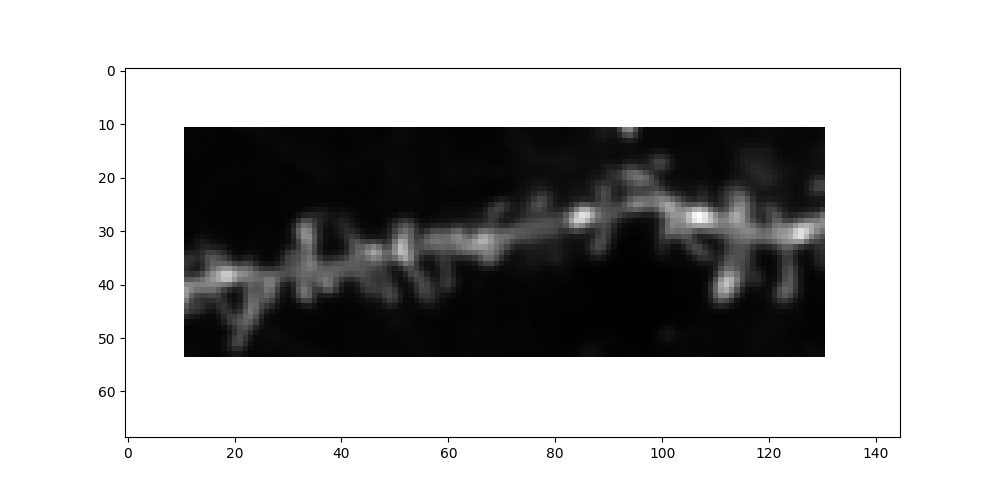

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools

# Assuming fns, Mpad, template, maxshift, meanIM, actIM, peaks, rawIMs are defined

motOutput = np.zeros((2, len(strict_matching_files)))
corrCoeff = np.zeros(len(strict_matching_files))
meanAligned = np.zeros_like(meanIM)
actAligned = np.zeros_like(actIM)
peaksCat = {'row': [], 'col': [], 'val': [], 't': []}

# Define a list of colors to cycle through
colors = itertools.cycle(['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown'])

# Display the template image once
plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(template, cmap='gray')

# Iterate through trials in reverse order
for trialIx in range(len(strict_matching_files) - 1, -1, -1):
    
    mot1, _ = xcorr2_nans(Mpad[:, :, trialIx], template, [0, 0], maxshift)
  
    motOutput[:, trialIx], corrCoeff[trialIx] = xcorr2_nans(Mpad[:, :, trialIx], template, np.round(mot1).astype(int), maxshift)
    print(motOutput[:, trialIx], corrCoeff[trialIx])
    # break
    rr, cc = np.meshgrid(np.arange(meanIM.shape[0]), np.arange(meanIM.shape[1]), indexing='ij')
    
    for chIx in range(meanIM.shape[2]):
        map_x = cc + motOutput[1, trialIx]
        map_y = rr + motOutput[0, trialIx]
        
        meanAligned[:, :, chIx, trialIx] = cv2.remap(meanIM[:, :, chIx, trialIx], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        
        actAligned[:, :, chIx, trialIx] = cv2.remap(actIM[:, :, chIx, trialIx], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
    
    if trialIx == len(strict_matching_files) - 1:
        peaksCat['row'] = peaks[trialIx]['row'] - motOutput[0, trialIx]
        peaksCat['col'] = peaks[trialIx]['col'] - motOutput[1, trialIx]
        peaksCat['val'] = peaks[trialIx]['val']
        peaksCat['t'] = peaks[trialIx]['t']
    else:
        peaksCat['row'] = np.concatenate((peaks[trialIx]['row'] - motOutput[0, trialIx], peaksCat['row']))
        peaksCat['col'] = np.concatenate((peaks[trialIx]['col'] - motOutput[1, trialIx], peaksCat['col']))
        peaksCat['val'] = np.concatenate((peaks[trialIx]['val'], peaksCat['val']))
        peaksCat['t'] = peaksCat['t'] + rawIMs[trialIx].shape[2]
        peaksCat['t'] = np.concatenate((peaks[trialIx]['t'], peaksCat['t']))
    
    # Overlay scatter plot for current trial with a different color
    color = next(colors)
    plt.scatter(maxshift + np.array(peaks[trialIx]['col']) - motOutput[1, trialIx], 
                maxshift + np.array(peaks[trialIx]['row']) - motOutput[0, trialIx], 
                edgecolors=color, facecolors='none', label=f'Trial {trialIx + 1}')
    # C_GT = GT[0]
    # R_GT = GT[1]
    # plt.scatter(R_GT, C_GT, marker='x', c='yellow', s=100)
# Add legend to the plot
plt.legend()
# Show the final plot with all scatter points
plt.show()

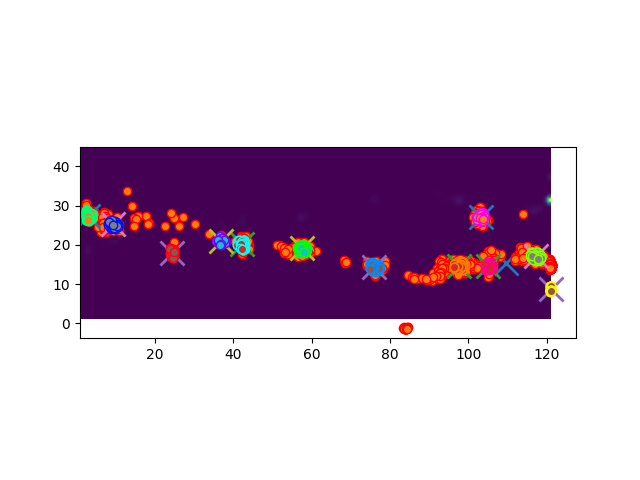

TypeError: only integer scalar arrays can be converted to a scalar index

In [16]:
import numpy as np
from functools import reduce

cc = corrCoeff
forceCorrThresh = None  # or some other initial value
cc = corrCoeff
if forceCorrThresh is not None and forceCorrThresh > 0:
    corrThresh = forceCorrThresh
else:
    corrThresh = min(0.96, np.median(cc) - 2 * np.std(cc))

validTrials = np.where(cc > corrThresh)
exptSummary = {}
exptSummary['meanIM'] = np.nanmean(meanAligned, axis=3)
exptSummary['actIM'] = np.nanmean(actAligned, axis=3)

# Define the sources dictionary
sources = {'R': [], 'C': []}

# cluster localizations
totalFrames = sum([x.shape[2] for x in rawIMs])
params['minEvents'] = totalFrames * params['frametime'] * params['dsFac'] * params['eventRateThresh_hz']
_, P, sources['R'], sources['C'], params = cluster_localizations(peaksCat, params)
k = len(sources['R'])  # number of sources
sz = params['sz']


# Generate IMsel; the data only in the selected region, aligned across movies
selPix = np.zeros(sz[:2], dtype=bool)
for sourceIx in range(k-1, -1, -1):
    rr = slice(max(0, round(sources['R'][sourceIx] - params['dXY'])), 
               min(sz[0], round(sources['R'][sourceIx] + params['dXY'])))
    cc = slice(max(0, round(sources['C'][sourceIx] - params['dXY'])), 
               min(sz[1], round(sources['C'][sourceIx] + params['dXY'])))
    selPix[rr, cc] = True

nSelPix = np.sum(selPix)  # number of selected pixels
dFsel = np.full((nSelPix, totalFrames), np.nan)  # extize
if numChannels == 2:
    dF2sel = np.full((nSelPix, totalFrames), np.nan)  # extize

baselineWindow = np.ceil(params['baselineWindow_Glu_s'] / (params['frametime'] * params['dsFac']))

frameInd = 0
for trialIx in validTrials:
    szTmp = rawIMs[trialIx].shape
    IMrawSel = interpArray(rawIMs[trialIx], np.any(selPix, axis=2), motOutput[:, trialIx])  # interpolates the movie at the shifted coordinates
    F0selDS[trialIx] = svdF0(IMrawSel.T, 3, baselineWindow).T  # Transpose for svdF0
    dFsel[:, frameInd:frameInd + szTmp[2]] = IMrawSel - F0selDS[trialIx]
    
    if numChannels == 2:
        IM2rawSel = interpArray(rawIM2s[trialIx], np.any(selPix, axis=2), motOutput[:, trialIx])  # interpolates the movie at the shifted coordinates
        F02selDS[trialIx] = svdF0(IM2rawSel.T, 3, baselineWindow).T  # Transpose for svdF0
        dF2sel[:, frameInd:frameInd + szTmp[2]] = IM2rawSel - F02selDS[trialIx]
    
    frameInd += szTmp[2]

# Test Xcorre Nans

In [35]:
import numpy as np
import time
import scipy.ndimage as ndimage
from skimage.filters import difference_of_gaussians
import matplotlib.pyplot as plt
from skimage.morphology import square
import numpy as np
from scipy.linalg import svd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.sparse.linalg import svds
from scipy.ndimage import convolve, shift
from scipy.stats import scoreatpercentile
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.io import savemat, loadmat
import pdb
from sklearn.decomposition import TruncatedSVD
from scipy.ndimage import binary_dilation

def xcorr2_nans(frame, template, shiftsCenter, dShift):
    """
    Perform a somewhat-efficient local normalized cross-correlation for images with NaNs.
    
    Parameters:
    - frame: the frame to be aligned; this has more NaNs
    - template: the template
    - shiftsCenter: the center offset around which to perform a local search
    - dShift: the maximum shift (scalar, in pixels) to consider on each axis around shiftsCenter
    
    Returns:
    - motion: the calculated motion vector
    - R: the correlation coefficient
    """
    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.bool_)
    # Create structuring element for dilation
    # SE = generate_binary_structure(dShift, 1)
    # SE = binary_dilation(SE, iterations=dShift)
    
    # Valid pixels of the new frame
    fValid = ~np.isnan(frame) & shift(~binary_dilation(np.isnan(template), structure=SE), shiftsCenter)
    fValid[:dShift, :] = False
    fValid[-dShift:, :] = False
    fValid[:, :dShift] = False
    fValid[:, -dShift:] = False

    # fValid_mat = loadmat('/root/capsule/scratch/fValid.mat')['fValid']
    # print('fValid mat--->', np.allclose(fValid, fValid_mat, equal_nan=True))

    # shiftsCenter = np.array(shiftsCenter) 
    tValid = np.roll(fValid, shift=-np.array(shiftsCenter))

    # F = frame[fValid]  # fixed data

    # Flatten both arrays in column-major order
    frame_flattened = frame.flatten(order='F')
    fValid_flattened = fValid.flatten(order='F')

    # Use the flattened boolean array to index the flattened frame array
    F = frame_flattened[fValid_flattened]
    
    ssF = np.sqrt(np.sum(F**2))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    shifts = np.arange(-dShift, dShift + 1)

    C = np.full((len(shifts), len(shifts)), np.nan)
    
    # for drix in range(len(shifts)):
    #     for dcix in range(len(shifts)):
    #         T = template[np.roll(tValid, (-shifts[drix], shifts[dcix]), axis=(0, 1))]
    #         ssT = np.sum(T**2)
    #         C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)

    # Flatten the template array in column-major order
    template_flattened = template.flatten(order='F')

    # Iterate over the shifts
    for drix in range(len(shifts)):
        for dcix in range(len(shifts)):
            # Roll the tValid array
            rolled_tValid = np.roll(tValid, (-shifts[drix], shifts[dcix]), axis=(1, 0))
            
            # Flatten the rolled tValid array in column-major order
            rolled_tValid_flattened = rolled_tValid.flatten(order='F')

            # Apply boolean indexing to get the template values
            T = template_flattened[rolled_tValid_flattened]

            # Calculate ssT and C
            ssT = np.sum(T**2)
            C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)

    C = C.T[::-1] # To match the way matlab computes

    # C_mat = loadmat('/root/capsule/scratch/C.mat')['C']
    # print('C mat--->', np.allclose(C, C_mat, equal_nan=True))   
           
    # Find maximum of correlation map
    maxval = np.max(C)
    I = np.argmax(C)
    if np.isnan(maxval):
        raise ValueError("All-NaN slice encountered in cross-correlation.")
    
    rr, cc = np.unravel_index(np.nanargmax(C), C.shape)
    R = maxval / ssF  # correlation coefficient

    if rr > 1 and rr < len(shifts) and cc > 1 and cc < len(shifts):
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2

        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2

        motion = shiftsCenter + np.array([shifts[rr] - dR, shifts[cc] - dC])
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + np.array([shifts[rr], shifts[cc]])

    if np.any(np.isnan(motion)):
        raise ValueError("NaN encountered in motion calculation.")

    return motion, R

frame = loadmat('/root/capsule/scratch/xcorrNans_test.mat')['frame']
template = loadmat('/root/capsule/scratch/xcorrNans_test.mat')['template']
shiftsCenter = [0, 0] #loadmat('/root/capsule/scratch/xcorrNans_test.mat')['shiftsCenter'][0]
dShift = 12 #loadmat('/root/capsule/scratch/xcorrNans_test.mat')['dShift'][0][0]

motion, R = xcorr2_nans(frame, template, shiftsCenter, dShift)

fValid mat---> True
C mat---> True
R 0.9999646598123011


In [36]:
motion, R

(array([0.01419478, 0.00755934]), 0.9999646598123011)

# Test Decorrelate motion

In [ ]:
from sklearn.decomposition import TruncatedSVD

def decorrelate_motion(IM, IMstruct, aData, window):

    IM_Deco = loadmat('/root/capsule/scratch/IM_deco_first.mat')['IM']
    print('IM mat--->', np.allclose(IM, IM_Deco, equal_nan=True))

    IMavg = IMstruct
    # print('IMavg----->', IMavg)
    IMavg_mat = loadmat('/root/capsule/scratch/IMstruct.mat')['IMstruct']
    # print('IMavg mat ----->', IMavg_mat)
    print('IMavg_mat--->', np.allclose(IMavg_mat, IMavg, equal_nan=True))

    nanFrames = np.all(np.isnan(IM), axis=(0, 1))

    nanFrames_mat = loadmat('/root/capsule/scratch/nanFrames_deco.mat')['nanFrames']
    print('nanFrames-->', np.allclose(nanFrames_mat, nanFrames))

    # Replace NaNs with zeros
    IMnan = np.isnan(IM)

    IMnan_mat = loadmat('/root/capsule/scratch/IMnan_deco.mat')['IMnan']
    print('IMnan_deco-->', np.allclose(IMnan_mat, IMnan))

    goodPixels = np.mean(~IMnan, axis=2) > 0.9
    goodPixels_mat = loadmat('/root/capsule/scratch/goodPixels_deco.mat')['goodPixels']
    print('goodPixels-->', np.allclose(goodPixels_mat, goodPixels))

    IM2 = IM.copy()
    IM2[IMnan] = 0

    IM2_IMnan_mat = loadmat('/root/capsule/scratch/IM2_IMnan_deco.mat')['IM2']
    print('IM2_IMnan_mat-->', np.allclose(IM2_IMnan_mat, IM2))

    # Select non-NaN frames
    IM2 = IM2[:, :, ~nanFrames]

    # Reshape
    sz = IM2.shape
    IM2 = IM2.reshape(sz[0] * sz[1], sz[2], order='F')

    IM2_reshape_mat = loadmat('/root/capsule/scratch/IM2_reshape_deco.mat')['IM2']
    print('IM2_reshape_mat-->', np.allclose(IM2_reshape_mat, IM2))

    # Subtract mean
    IM2 = IM2.astype(np.float64)  # Convert IM2 to double precision
    IM2 = IM2 - np.mean(IM2, axis=1, keepdims=True)

    IM2_reshape_mean_subs_mat = loadmat('/root/capsule/scratch/IM2_reshape_mean_subs_deco.mat')['IM2']
    print('IM2_reshape_mean_subs--->', np.allclose(IM2_reshape_mean_subs_mat, IM2))

    # def imtranslate(image, shift_val):
    #     return shift(image, shift_val, mode='nearest')

    # imageGrads = np.dstack([
    #     IMavg - imtranslate(IMavg, [1, 0]),
    #     IMavg - imtranslate(IMavg, [0, 1]),
    #     IMavg - imtranslate(IMavg, [-1, 0]),
    #     IMavg - imtranslate(IMavg, [0, -1])
    # ])

    # Function to translate the image
    def translate_image(image, x_shift, y_shift):
        rows, cols = image.shape[:2]
        M = np.float64([[1, 0, x_shift], [0, 1, y_shift]])
        translated_image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_LINEAR)
        return translated_image

    # Translate the image in four directions
    translated_right = translate_image(IMavg, 1, 0)
    translated_down = translate_image(IMavg, 0, 1)
    translated_left = translate_image(IMavg, -1, 0)
    translated_up = translate_image(IMavg, 0, -1)

    # Compute the gradients
    grad_right = IMavg - translated_right
    grad_down = IMavg - translated_down
    grad_left = IMavg - translated_left
    grad_up = IMavg - translated_up

    # Concatenate the gradients along a new third dimension
    imageGrads = np.stack((grad_right, grad_down, grad_left, grad_up), axis=-1)

    imageGrads_mat = loadmat('/root/capsule/scratch/imageGrads_deco.mat')['imageGrads']
    print('imageGrads_mat--->', np.allclose(imageGrads_mat, imageGrads, equal_nan=True))

    # print(np.nanmax(np.abs(imageGrads_mat - imageGrads)))

    # print(np.nanmax(np.abs((imageGrads_mat - imageGrads)/(imageGrads_mat+1e-12))))

    # print(np.all(np.isnan(imageGrads_mat) == np.isnan(imageGrads)))

    # plt.imshow(imageGrads[:,:,0])
    # plt.show()

    imageGrads = imageGrads.reshape(sz[0] * sz[1], -1, order='F')
    imageGrads_reshape_mat = loadmat('/root/capsule/scratch/imageGrads_reshape_deco.mat')['imageGrads']
    print('imageGrads_reshape_mat--->', np.allclose(imageGrads_reshape_mat, imageGrads, equal_nan=True))

    nPCs = 20

    # Select the rows of IM2 corresponding to goodPixels
    IM2_subset = IM2[goodPixels.flatten(order = 'F'), :]

    IM2_subset_mat = loadmat('/root/capsule/scratch/IM2_subset_deco.mat')['IM2_subset']
    print('IM2_subset mat--->', np.allclose(IM2_subset, IM2_subset_mat))

    # print('IM2_subset --->', IM2_subset)
    # Perform SVD
    svd = TruncatedSVD(n_components=nPCs, algorithm='arpack', n_iter=15)
    U = svd.fit_transform(IM2_subset)
    S = svd.singular_values_
    Vt = svd.components_

    print('U.shape, S.shape, Vt.shape', U.shape, S.shape, Vt.shape)

    # print('U*np.diag(S)*V--->', U@np.diag(S)@Vt)

    # print('U*Vt--->', U@Vt)

    U = U/S[None, :]

    print('U*np.diag(S)*V after--->', U@np.diag(S)@Vt)

    # Reverse the outputs as svds returns them in ascending order
    # idx = np.argsort(-S)
    # S = S[idx]
    # U = U[:, idx]
    # V = Vt.T[:, idx]

    print('U---->', U)
    print('S---->', S)
    print('V---->', Vt)

    

    svd_mat_contents = loadmat('/root/capsule/scratch/svd_deco.mat')
    U_mat = svd_mat_contents['U']
    V_mat = svd_mat_contents['V']
    S_mat = svd_mat_contents['S']

    print('S mat--->', np.allclose(np.diag(S), S_mat))
    print('U mat--->', np.allclose(U, U_mat))
    # print('V mat--->', np.allclose(Vt, V_mat))

    print(np.nanmax(np.abs(U_mat - U)))

    print(np.nanmax(np.abs((U_mat - U)/(U_mat+1e-12))))

    # Assuming imageGrads and U are numpy arrays
    X = imageGrads[goodPixels.flatten(order = 'F'), :]
    X_mat = loadmat('/root/capsule/scratch/X_deco_mat.mat')['X']
    print('X mat--->', np.allclose(X_mat, X))

    y = U

    # Create a LinearRegression object
    model = LinearRegression()

    # Fit the model to the data
    model.fit(X, y)

    # Get the coefficients (equivalent to b in MATLAB code)
    bt = model.coef_
    b = bt.T
    print('b * V.T--->', np.dot(b,Vt))
    print('b--->', b)

    b_mat = loadmat('/root/capsule/scratch/b_deco.mat')['b']
    print('b mat--->', np.allclose(b, b_mat))

    # b = np.linalg.lstsq(imageGrads[goodPixels.ravel(), :], U, rcond=None)[0]
    correction = (imageGrads @ b) @ np.diag(S) @ Vt

    print('correction----->', correction)

    correction_deco = loadmat('/root/capsule/scratch/correction_deco.mat')['correction']
    print('correction_deco mat--->', np.allclose(correction, correction_deco, atol=1e-01))

    print(np.nanmax(np.abs(correction_deco - correction)))
    print(np.nanmax(np.abs((correction_deco - correction)/(correction_deco+1e-12))))
    
    correction_deco_reshape = loadmat('/root/capsule/scratch/corection_reshape_deco.mat')['correction_reshape']
    print('correction.reshape mat ---->', np.allclose(correction.reshape(sz[0], sz[1], -1), correction_deco_reshape, atol=1e-01))
    print(np.nanmax(np.abs(correction_deco_reshape - correction.reshape(sz[0], sz[1], -1))))
    print(np.nanmax(np.abs((correction_deco_reshape - correction.reshape(sz[0], sz[1], -1))/(correction_deco_reshape+1e-12))))

    IM[:, :, ~nanFrames] -= np.reshape(correction, (sz[0], sz[1], -1), order='F')
    return IM, correction

II, correction = decorrelate_motion(IMf, IMstruct, aData, params)

IM mat---> False
IMavg_mat---> True
nanFrames--> True
IMnan_deco--> True
goodPixels--> True
IM2_IMnan_mat--> False
IM2_reshape_mat--> False
IM2_reshape_mean_subs---> False
imageGrads_mat---> True
imageGrads_reshape_mat---> True
IM2_subset mat---> False
U.shape, S.shape, Vt.shape (5117, 20) (20,) (20, 5000)
U*np.diag(S)*V after---> [[   29.40388164   247.28346509  -116.74656573 ...    39.77620982
    132.69307241    47.76774459]
 [   64.4317883    265.8934916     38.68090049 ...   -35.61253746
    148.15647988    58.59953043]
 [   89.86293454   264.74144854   138.87395236 ...   -84.70371757
    149.31063781    53.62343608]
 ...
 [ -330.09387706  -544.48277484   250.53548998 ...   -67.02406688
   -143.26740338  -322.18201256]
 [ -531.73891137  -889.53548126   490.51486528 ...   -59.47325869
   -258.68839992  -392.04577915]
 [ -612.95219533 -1099.76379506   640.50531495 ...   -44.65058669
   -328.68944593  -384.1617094 ]]
U----> [[-2.52238464e-03 -4.56572734e-04 -5.67323440e-04 ... -9.983

In [ ]:
IM_final_Deco = loadmat('/root/capsule/scratch/IM_final_deco.mat')['IM']
print('IM_final decorrelation mat--->', np.allclose(IM_final_Deco, II, atol=1e-01, equal_nan=True))

print(np.nanmax(np.abs(IM_final_Deco - II)))

print(np.nanmax(np.abs((IM_final_Deco - II)/(IM_final_Deco+1e-12))))

IM_final decorrelation mat---> False
17.577257249886316
2535.5598431759336


In [ ]:
correction_rounded = np.round(correction)
correction_deco_rounded = np.round(correction_deco)

print('correction_deco mat--->', np.allclose(correction_rounded, correction_deco_rounded, atol=1e-01))

# Find coordinates where they are not the same
not_equal_coords = np.where(correction_rounded != correction_deco_rounded)
print('Coordinates where correction and correction_deco are not equal:', not_equal_coords)

NameError: name 'correction_deco' is not defined

In [ ]:
correction_deco_rounded[0,4], correction_rounded[0,4]

(119.0, 120.0)

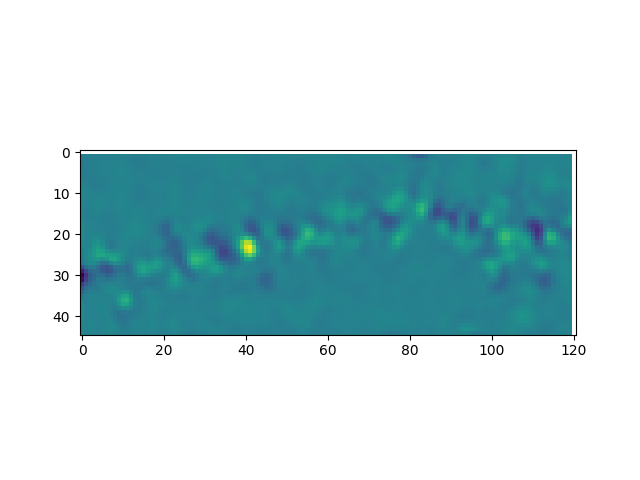

In [ ]:
plt.imshow(II[:,:,3588])
plt.show()

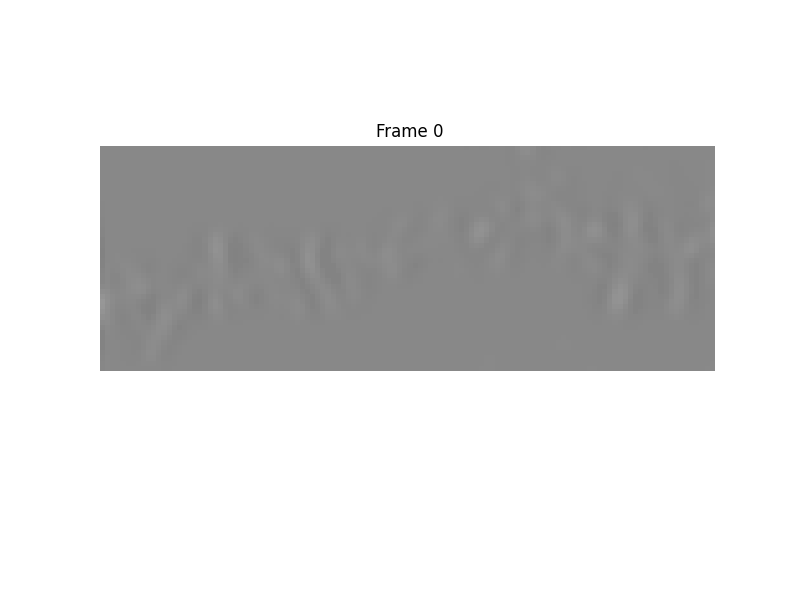

In [ ]:
play_movie(II-IM_final_Deco)

In [ ]:
play_movie(II)

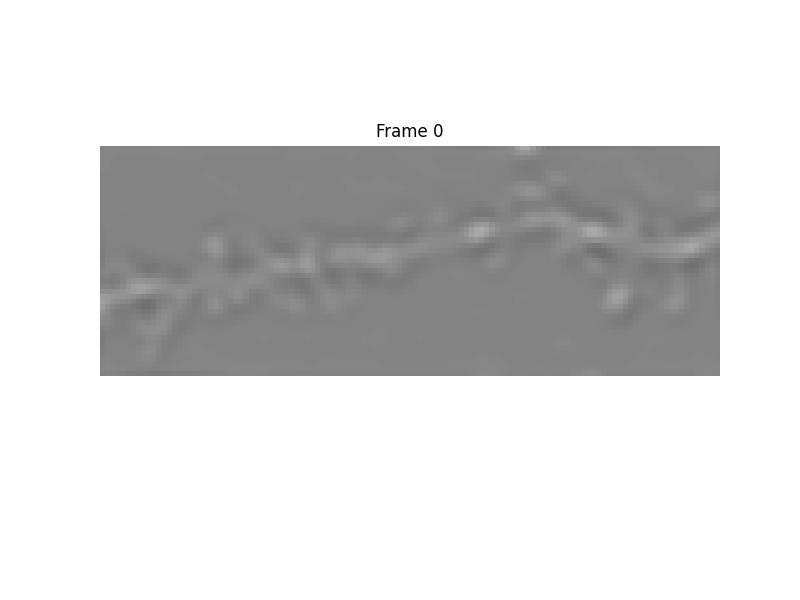

In [ ]:
sz = [45,121,5000]
play_movie(np.reshape(correction, (sz[0], sz[1], -1), order='F'))